# **Catch Me If You Can ("Alice")**
### Intruder Detection through Webpage Session Tracking

**Description / Задание:**

(Russian version below)


Web-user identification is a hot research topic on the brink of sequential pattern mining and behavioral psychology.

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages. The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person) and predict whether it belongs to Alice or somebody else.

The data comes from Blaise Pascal University proxy servers. Paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud.


Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

**Target / Целевая переменная:**

Target

**Evaluation / Метрика для оценки:**


The target metric is ROC AUC. / Целевая метрика – ROC AUC.

**Data Description**

(Russian version below)

The train set train_sessions.csv contains information on user browsing sessions where the features are:

site_i – are ids of sites in this session. The mapping is given with a pickled dictionary site_dic.pkl
time_j – are timestamps of attending the corresponding site
target – whether this session belongs to Alice
One can use the original data train.zip to form a train set differing from train_sessions.csv.


В обучающей выборке train_sessions.csv:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
Признаки time_j – время посещения сайтов site_j
Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)
Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис. Не обязательно ограничиваться только предложенной выборкой train_sessions.csv – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

### Описание датасета:

* **site1** - индекс 1-го посещенного сайта в сессии
* **time1** - время посещения 1-го сайта в сессии
* **...**
* **site10** - индекс 10-го посещенного сайта в сессии
* **time10** - время посещения 10-го сайта в сессии
* **target** – целевая переменная, принимает значение 1 для сессий Элис и 0 для сессий других пользователей

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))
from IPython.display import display_html

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install eli5

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [6]:
TRAIN_DATASET_PATH = './train_sessions.csv'
TEST_DATASET_PATH = './test_sessions.csv'
SITE_DIC_PATH = './site_dic.pkl'
RES_PATH = './result_submission.csv'

### Создание функции и загрузка данных

In [7]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    train_df = train_df.sort_values(by='time1')
    
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    id2site = {v:k for (k, v) in site2id.items()}
    id2site[0] = 'unknown'
    
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [9]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(TRAIN_DATASET_PATH),
    path_to_test=os.path.join(TEST_DATASET_PATH),
    path_to_site_dict=os.path.join(SITE_DIC_PATH),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

Wall time: 42.8 s


### Алгоритм - LogisticRegression

In [10]:
time_split = TimeSeriesSplit(n_splits = 10)

In [11]:
model_lr = LogisticRegression(C=1, random_state = 17, solver='liblinear')

In [12]:
# Функция для записи предсказаний в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [13]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=25, submission_file_name=RES_PATH):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

### Разведочный анализ данных - Exploratory Data Analysis(EDA)

In [14]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

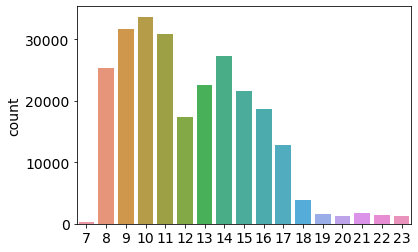

In [15]:
sns.countplot(session_start_hour);

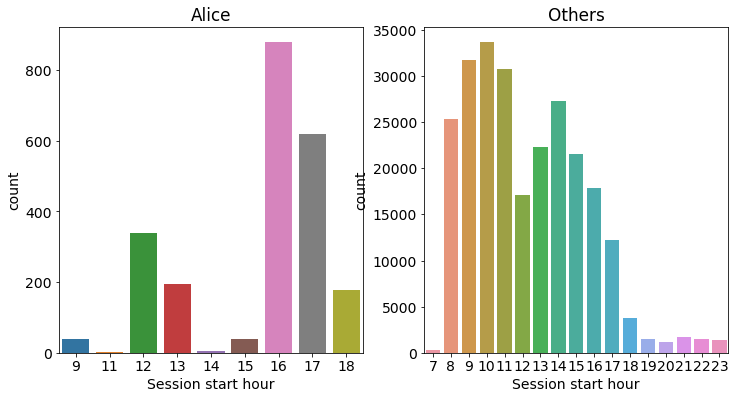

In [16]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title('Alice')
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

### Feature engineering

In [17]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [18]:
def add_time_features(times, X_sparse):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    X = hstack(objects_to_hstack)
    return X, feature_names

In [19]:
%%time
X_train_with_times, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times, _ = add_time_features(test_times, X_test_sites)

Wall time: 3.63 s


### Масштабирование признаков

In [20]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [21]:
X_train_with_time_correct = hstack([X_train_with_times, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times, test_dur_scaled])

### Feature engineering

In [22]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5 # 100000
    
    objects_to_hstack = [X_sparse, day_of_week, year_month]
    feature_names = ['day_of_week', 'year_month']    
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [23]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

### Прогнозирование и сохранение результатов

In [24]:
cv_scores = train_and_predict(model=model_lr, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name=RES_PATH)

CV scores [0.84087949 0.81419332 0.91835374 0.96200556 0.91565599 0.95642539
 0.92852225 0.94887168 0.95780885 0.96746118]
CV mean: 0.9210177460170227, CV std: 0.050145670154854244


Weight?,Feature
+5.008,www.express.co.uk
+4.941,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.857,youwatch.org
+4.829,vk.com
+4.465,www.info-jeunes.net
+4.367,www.melty.fr
+4.222,fr.glee.wikia.com
+4.066,www.audienceinsights.net
+4.065,www.banque-chalus.fr
+3.930,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
         feature     coef
0        morning -1.65409
1            day  2.10543
2        evening -1.59974
3          night  0.00000
4  sess_duration -0.26795
5    day_of_week -0.32235
6     year_month -2.62509


In [40]:
import dill

with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(train_and_predict, f)